The dataset I am experimenting is the spam.csv dataset from one of the Kaggle competitions.

In [1]:
import pandas as pd
import numpy as np

In [86]:
msg = pd.read_csv('spam.csv', encoding = 'latin-1')

msg.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


There are 2 lables present: ham (legitimate) and spam.

In [87]:
msg.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


We see columns [Unnamed: 2	Unnamed: 3	Unnamed: 4] have very few counts compared to the other two and most of that are NaN. So we will remove them.

In [88]:
msg = msg[['v1','v2']]

msg.rename(columns={"v1": "label", "v2": "message"}, inplace= True)

msg.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Next, we need to enconde "ham" and "spam" labels numerically. Let's set "ham" = 0 and "spam" = 1.

In [89]:
msg['label'][msg['label'] == 'ham'] = 0
msg['label'][msg['label'] == 'spam'] = 1

First of all, we need to convert all upper case to lower case to make sure that for the same word, they are classifed as the same. 

In [6]:
def lower(x):
    return x.lower()

I will make use of NTLK for further processing the messages. Next, we need to tonkenize each message. It is to split up a message into distinct pieces and disregards unimportant parts such as punctuation and stop words.

In [8]:
import nltk
#nltk.download('punkt')

In [9]:
from nltk.tokenize import word_tokenize

In [10]:
def tokenize(x):
    comps = word_tokenize(x)
    comps = [i for i in comps if len(i) > 1]
    return comps

Next, we need to remove the stop words which are those that occur frequently such as articles.

In [12]:
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [13]:
eng_sw = stopwords.words('english') #list of all stop words in English

In [14]:
def stopword(x):
    x = [i for i in x if i not in eng_sw ]
    return x

Next, I will apply a algorithm called Lemmatization to reduce noise in the text by transforming the words to their base form. For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words.

In [16]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


In [17]:
def lemmatizer(x):
    x = [WordNetLemmatizer().lemmatize(i, pos ="v") for i in x]
    return " ".join(i for i in x)

In [85]:
def preprocess(x):
    x = lower(x)
    x = tokenize(x)
    x = stopword(x)
    x = lemmatizer(x)
    return x

In [90]:
msg['message'] = msg['message'].apply(preprocess)
msg.head()

,label,message
0,0,go jurong point crazy.. available bugis great ...
1,0,ok lar ... joke wif oni ...
2,1,free entry wkly comp win fa cup final tkts 21s...
3,0,dun say early hor ... already say ...
4,0,nah n't think go usf live around though


Let's do some EDA and visualization before we split the data set

In [19]:
print("Proportion of spam: {}".format(msg['label'].value_counts()[1]/(len(msg))))

Proportion of spam: 0.13406317300789664


Let's get a word cloud to see which words appear most in spam

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [21]:
seperator = " "
spam_words = seperator.join([str(i) for i in list(msg[msg['label'] == 1]['message'])])

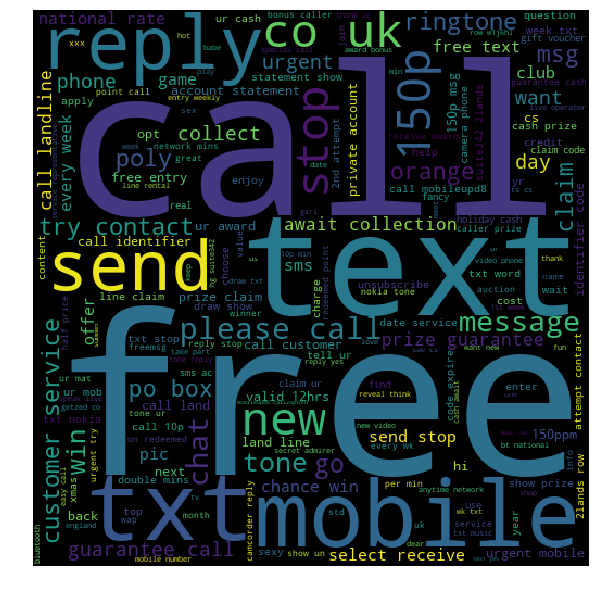

In [22]:
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'w')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In contrast, legitimate messages would have:

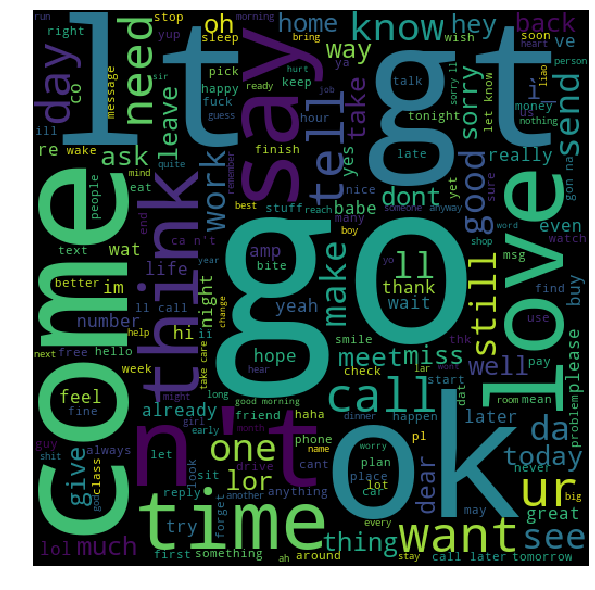

In [23]:
legit_words = seperator.join([str(i) for i in list(msg[msg['label'] == 0]['message'])])
legit_wc = WordCloud(width = 512,height = 512).generate(legit_words)
plt.figure(figsize = (10, 8), facecolor = 'w')
plt.imshow(legit_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

For our training purposes, we will need a train set and a test set. Hence, we'll do so.

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(msg['message'], msg['label'], test_size = 0.2, random_state = 1)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

For the problem we'll implement the TF-IDF vectorizer, which stands for Term Frequency-Inverse Document Frequency. Term frequency is the proportion of number of occurences of a word over the the total number of words in the dataset.

Inverse Document Frequency is the log of the proportion of the total number of messages over the total number of messages containing a word, thus highlighting the rarity of the word.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x_train = vectorizer.fit_transform(x_train)

In [26]:
from sklearn.linear_model import LogisticRegression

logRegress = LogisticRegression()

logRegress.fit(x_train, y_train)

C:\Users\tring\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(x_train, y_train)

C:\Users\tring\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
x_test = vectorizer.transform(x_test)

In [29]:
from sklearn.metrics import confusion_matrix
y_pred = svm.predict(x_test) 
print(confusion_matrix(y_test, y_pred))

print("Accuracy of SVM model: {}".format((confusion_matrix(y_test, y_pred)[0][0] + confusion_matrix(y_test, y_pred)[1][1]) /len(y_test)))

[[974   2]
 [ 20 119]]
Accuracy of SVM model: 0.9802690582959641


In [30]:
y_pred_2 = logRegress.predict(x_test) 
print(confusion_matrix(y_test, y_pred_2))

print("Accuracy of Logit model: {}".format((confusion_matrix(y_test, y_pred_2)[0][0] + confusion_matrix(y_test, y_pred_2)[1][1]) /len(y_test)))

[[973   3]
 [ 21 118]]
Accuracy of Logit model: 0.97847533632287


Both logistic regression and SVM performs similarly.

Let's test with some external data

In [157]:
new_msg = ["URGENT!!!! CLAIM YOUR MONEY $$$", "YOU are being investigated by the federal", "REPLY TO CLAIM FIVE STAR PACKAGE", "LOAN OFFER Are you in need of a loan for your business"]

new_msg = pd.DataFrame(new_msg)[0].apply(preprocess)

In [158]:
new_msg

0               urgent claim money
1              investigate federal
2    reply claim five star package
3    loan offer need loan business
Name: 0, dtype: object

In [159]:
new_msg = vectorizer.transform(new_msg)

In [160]:
svm.predict(new_msg) #2 out of 4 correct

array([1, 0, 1, 0])

In [161]:
logRegress.predict(new_msg) #1 out of 4 correct

array([1, 0, 0, 0])